# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
First give paths and values to all variables. Then, load in data.

Python imports:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

import subprocess

Input data paths. Currently hardcoded.

In [2]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'

Global variables for this notebook:

In [3]:
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_rich = ['#D81B60', '#1E88E5', '#FFC107', '#004D40']

### Load data

**Transcriptome** viral barcode frequencies:

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0,0.000000,False
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0,0.000000,False
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0,0.000000,False
3,AAACGAAGTACTTCCC,True,both,0.448272,fluHA,NaN,0,0.000000,False
4,AAACGAAGTAGACGTG,True,wt,0.040116,fluHA,AAGTAAGCGACATGAG,93,0.001731,True
...,...,...,...,...,...,...,...,...,...
9185,TTTGATCTCCCGTTCA,False,none,0.000109,fluNA,NaN,0,0.000000,False
9186,TTTGATCTCGCATTGA,True,wt,0.063156,fluNA,NaN,0,0.000000,False
9187,TTTGGAGAGTTGCCTA,False,none,0.000070,fluNA,NaN,0,0.000000,False
9188,TTTGGAGGTATCGTTG,True,wt,0.024534,fluNA,ACATCTTATTTACACG,15,0.000230,True


**Progeny** viral barcode frequencies:

In [6]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_count': 'count_progeny',
                                           'mean_freq': 'freq_progeny'}))
display(progeny_viral_bc_freqs)

,source,infecting_viral_tag,gene,viral_barcode,count_progeny,freq_progeny
0,second_infection,syn,fluHA,AAAACCTTCCGTACGT,1172.0,6.696768e-04
1,second_infection,syn,fluHA,AAAAGATCTTCGGTTT,529.0,8.867890e-04
2,second_infection,syn,fluHA,AAAAGGAAAGAAGTGC,1015.0,8.053109e-04
3,second_infection,syn,fluHA,AAAATAAAATAATGTT,33.0,1.885609e-05
4,second_infection,syn,fluHA,AAAATATACGTAAATC,0.5,2.856983e-07
...,...,...,...,...,...,...
11347,supernatant,wt,fluNA,TTTTCGTGAAAAGAGA,2638.5,1.747121e-03
11348,supernatant,wt,fluNA,TTTTGCTTCGAGATAG,22633.5,1.264800e-02
11349,supernatant,wt,fluNA,TTTTGGTTGTGAGGTG,0.5,2.399886e-07
11350,supernatant,wt,fluNA,TTTTGTTACATCATCT,0.5,2.399886e-07


Cell-gene matrix:

In [7]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3368 cells and 30959 genes


### Cross-check data
Use assert statements to ensure that that the number and identity of cell barcodes is identical between data sources.

In [8]:
assert transcriptome_viral_bc_freqs['cell_barcode'].nunique() == \
       adata.var['cell_barcode'].nunique(), \
       "Number of cells discrepancy"

assert set(transcriptome_viral_bc_freqs['cell_barcode']) == \
       set(adata.var['cell_barcode']), \
       "Cell barcodes do not match between data sources"

### Plot raw data
Plot data from each source without filtering or processing. This is mostly for exploration and transparency.

#### Viral barcode transcription

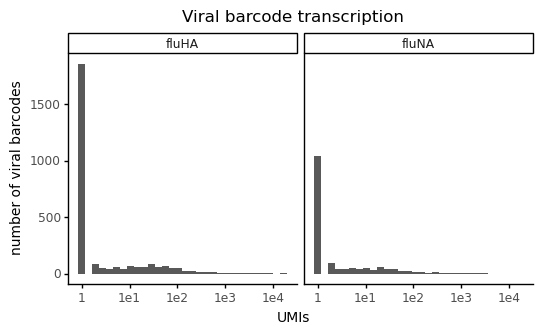

<ggplot: (8773332360512)>

In [9]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='UMIs',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

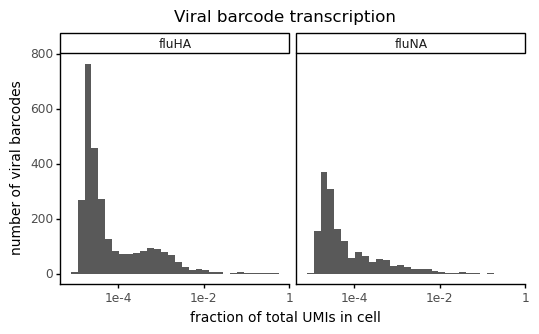

<ggplot: (8773332127558)>

In [10]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='fraction of total UMIs in cell',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

#### Progeny production

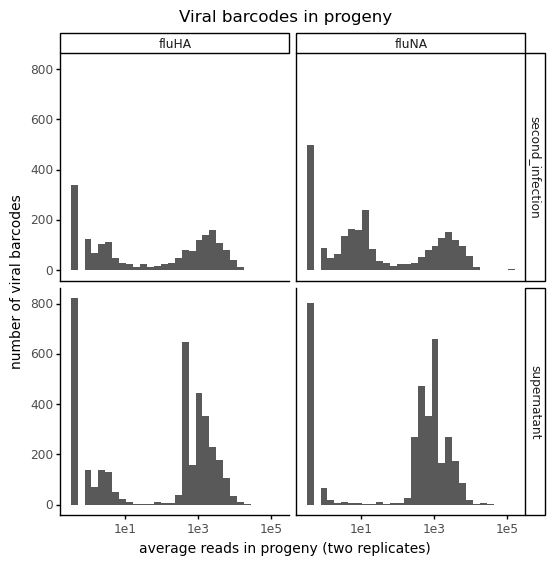

<ggplot: (8773332165623)>

In [11]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='count_progeny')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'Viral barcodes in progeny') +
       p9.labs(x='average reads in progeny (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

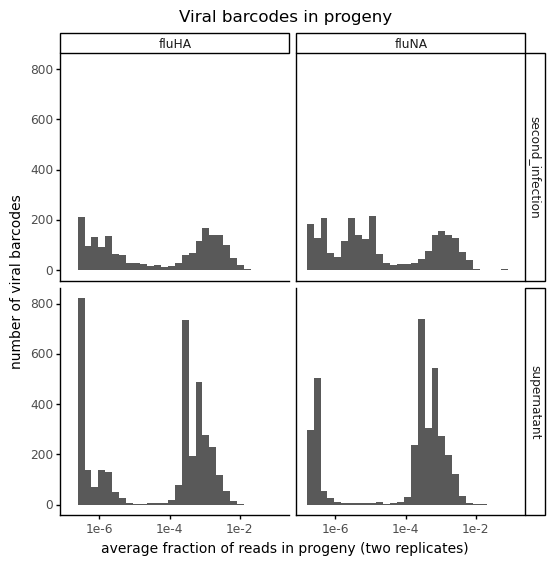

<ggplot: (8773330854394)>

In [12]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='freq_progeny')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'Viral barcodes in progeny') +
       p9.labs(x='average fraction of reads in progeny (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Process data
Next, I will merge the data into a few useable dataframes. I will perform calculations on these data that will help us visualize technical error and filter.

#### Merge all viral barcode data into a central dataframe called `viral_bc_freqs`

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene
5. Viral barcode
6. Count in the transcriptome (`viral_bc_UMIs`)
7. Frequency in transcriptome (`frac_viral_bc_UMIs`)
8. Progeny sample source (`source`)
8. Count in the progeny sequencing (`count_progeny`)
9. Frequency in progeny sequencing (`freq_progeny`)

First, make two copies of the data in `transcritome_viral_bc_freqs`. Assign one to each progeny source (`supernatant` or `second_infection`).

In [13]:
transcriptome_viral_bc_freqs = (
    pd.concat([transcriptome_viral_bc_freqs
               .assign(source=source)
               for source in ['supernatant', 'second_infection']]))
transcriptome_viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0,0.000000,False,supernatant
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0,0.000000,False,supernatant
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0,0.000000,False,supernatant
3,AAACGAAGTACTTCCC,True,both,0.448272,fluHA,NaN,0,0.000000,False,supernatant
4,AAACGAAGTAGACGTG,True,wt,0.040116,fluHA,AAGTAAGCGACATGAG,93,0.001731,True,supernatant
...,...,...,...,...,...,...,...,...,...,...
9185,TTTGATCTCCCGTTCA,False,none,0.000109,fluNA,NaN,0,0.000000,False,second_infection
9186,TTTGATCTCGCATTGA,True,wt,0.063156,fluNA,NaN,0,0.000000,False,second_infection
9187,TTTGGAGAGTTGCCTA,False,none,0.000070,fluNA,NaN,0,0.000000,False,second_infection
9188,TTTGGAGGTATCGTTG,True,wt,0.024534,fluNA,ACATCTTATTTACACG,15,0.000230,True,second_infection


Then, do the merge

In [14]:
viral_bc_freqs = pd.merge(
    left=transcriptome_viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag', 'source'])

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,count_progeny,freq_progeny
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,NaN,NaN
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,supernatant,NaN,NaN
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,supernatant,NaN,NaN
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,supernatant,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,7457.0,4.057614e-03
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,2638.5,1.747121e-03
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,0.5,2.399886e-07
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,0.5,2.399886e-07


Fill `NA` values in progeny with `0`. It is meaningful if a viral barcode is seen in the transcriptome but absent from the supernatant; no progeny was produced by that infected cell.

In [15]:
viral_bc_freqs = viral_bc_freqs

viral_bc_freqs[['count_progeny', 'freq_progeny']] = (
    viral_bc_freqs[['count_progeny', 'freq_progeny']]
    .fillna(0)
)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,count_progeny,freq_progeny
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,7457.0,4.057614e-03
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,2638.5,1.747121e-03
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,0.5,2.399886e-07
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,0.5,2.399886e-07


Get total UMIs per cell. Get viral UMI counts and fractions per cell. Assert that these match what is already found in `viral_bc_freqs`:

In [16]:
umi_counts = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                       .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            )
    )

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=umi_counts,
    how='outer',
    on=['cell_barcode'])

test_viral_frac_UMIs = pd.Series(
    viral_bc_freqs['viral_UMIs'] / viral_bc_freqs['total_UMIs'],
    name='frac_viral_UMIs')

pd.testing.assert_series_equal(
    test_viral_frac_UMIs, viral_bc_freqs['frac_viral_UMIs'])

viral_bc_freqs

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,count_progeny,freq_progeny,total_UMIs,viral_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,39505.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,7457.0,4.057614e-03,NaN,NaN
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,2638.5,1.747121e-03,NaN,NaN
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN


Do a quick check to make sure that the transcriptome measures ('infected', 'infecting_viral_tag', 'frac_viral_UMIs', 'total_UMIs', and 'viral_UMIs') are all the same for each cell barcode.

In [17]:
per_cell_measures = ['infected',
                     'infecting_viral_tag',
                     'frac_viral_UMIs',
                     'total_UMIs',
                     'viral_UMIs']

print('Checking that every cell is consistent '
      'with regard to the following measures:')
for measure in per_cell_measures:
    print('\n'+measure)
    print(all(viral_bc_freqs.groupby('cell_barcode')
              [f'{measure}'].nunique() == 1))
    assert all(viral_bc_freqs.groupby('cell_barcode') \
               [f'{measure}'].nunique() == 1)

Checking that every cell is consistent with regard to the following measures:

infected
True

infecting_viral_tag
True

frac_viral_UMIs
True

total_UMIs
True

viral_UMIs
True


#### Raw correlation of viral transcription and progeny production
Plot raw data:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


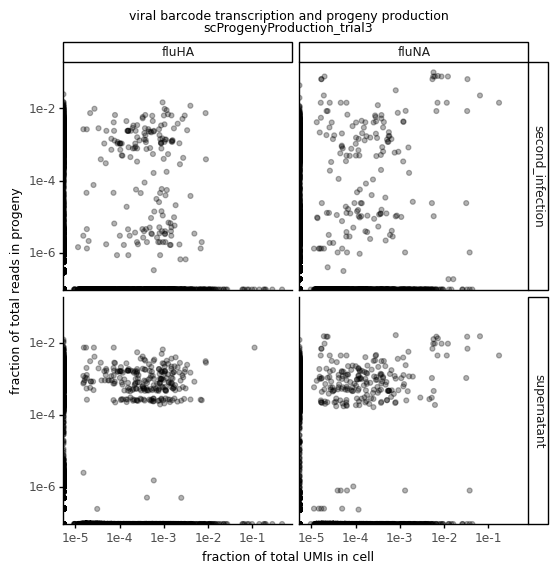

<ggplot: (8772667606125)>

In [18]:
fig = (p9.ggplot((viral_bc_freqs.fillna(0)),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle('viral barcode transcription and progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

#### Plot annotated by infection status

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


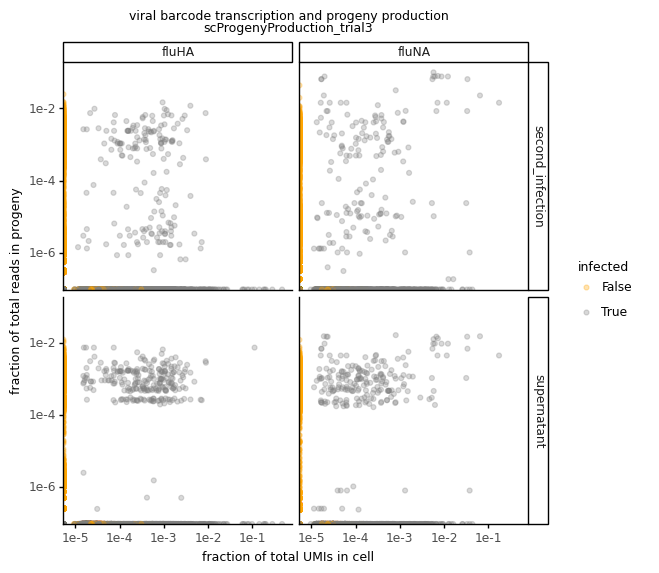

<ggplot: (8773332331948)>

In [19]:
fig = (p9.ggplot((viral_bc_freqs.fillna(0)),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle('viral barcode transcription and progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Plot annotated by variant

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


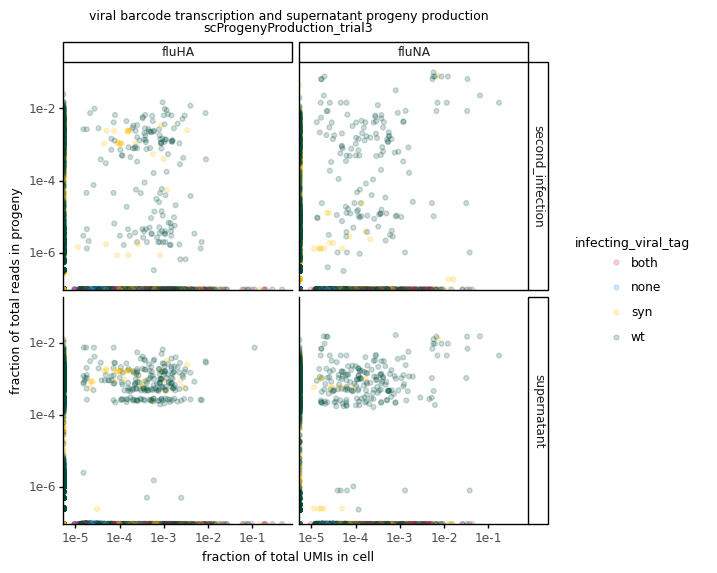

<ggplot: (8772667598373)>

In [20]:
fig = (p9.ggplot((viral_bc_freqs.fillna(0)),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.2) +
       p9.facet_grid('source~gene') +
       p9.ggtitle('viral barcode transcription and supernatant progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE_rich[0:]))
display(fig)

#### Significant viral barcodes found above background frequency in uninfected cells
During viral barcode processing from the transcriptome, the frequency of viral barcodes is calculated in uninfected cells. A poisson distribution is built around the expected number of UMIs for each cell-gene, and viral barcodes are called as significant if they reject the null hypothesis that they are pulled from this distribution.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


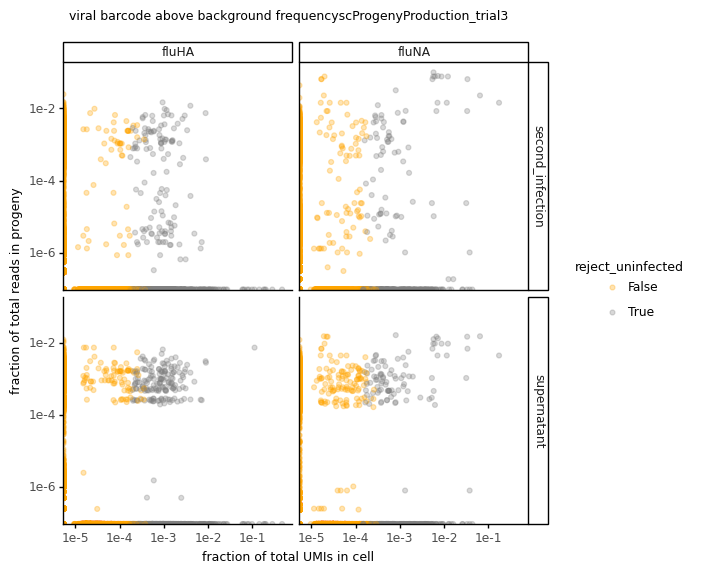

<ggplot: (8773332177908)>

In [21]:
fig = (p9.ggplot((viral_bc_freqs.fillna(0)),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='reject_uninfected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle('viral barcode above background frequency'
                  f'{expt}\n') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Viral barcode sharing across cells
How often is a significant viral barcode found in more than one cell? This should be very unlikely in a low MOI infection.

In [22]:
n_cell_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'viral_barcode',
                       'reject_uninfected'])
             ['cell_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'cell_barcode': 'n_cell_bc'}))

n_cell_bc

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_cell_bc,
    on=['infecting_viral_tag',
        'gene',
        'viral_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,count_progeny,freq_progeny,total_UMIs,viral_UMIs,n_cell_bc
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,39505.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,7457.0,4.057614e-03,NaN,NaN,NaN
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,2638.5,1.747121e-03,NaN,NaN,NaN
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN


Plot distribution of cell barcode per viral barcode.

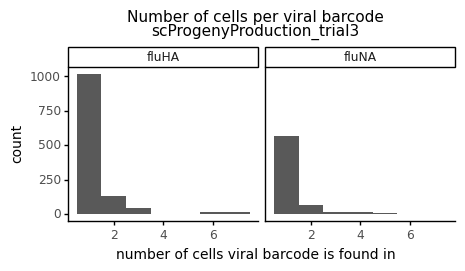

<ggplot: (8772646293417)>

In [23]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_cell_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of cells per viral barcode\n'
                  f'{expt}') +
       p9.xlab('number of cells viral barcode is found in') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label viral barcodes that are found in more than 1 cells.

In [24]:
viral_bc_freqs['gt1_cell'] = (
    viral_bc_freqs['n_cell_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,count_progeny,freq_progeny,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,39505.0,2.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,7457.0,4.057614e-03,NaN,NaN,NaN,False
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,2638.5,1.747121e-03,NaN,NaN,NaN,False
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False


Plot number of viral barcodes that were found in more than 1 cell:

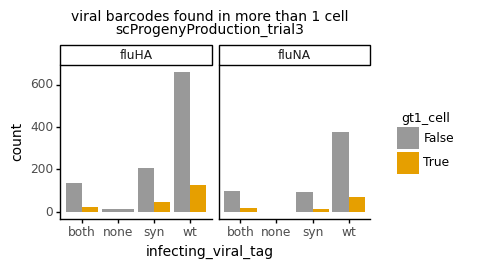

<ggplot: (8773330978039)>

In [25]:
fig = (p9.ggplot((viral_bc_freqs
                  .query('(reject_uninfected == True) and '
                         '(cell_barcode.notna())',
                         engine='python')),
                 p9.aes(x='infecting_viral_tag',
                        fill='gt1_cell')) +
       p9.geom_bar(stat='count', position='dodge') +
       p9.ggtitle('viral barcodes found in more than 1 cell\n'
                  f'{expt}') +
       p9.facet_grid('~gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

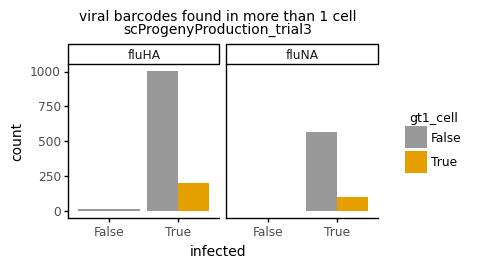

<ggplot: (8772646299667)>

In [26]:
fig = (p9.ggplot((viral_bc_freqs
                  .query('(reject_uninfected == True) and '
                         '(cell_barcode.notna())',
                         engine='python')),
                 p9.aes(x='infected',
                        fill='gt1_cell')) +
       p9.geom_bar(stat='count', position='dodge') +
       p9.ggtitle('viral barcodes found in more than 1 cell\n'
                  f'{expt}') +
       p9.facet_grid('~gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Plot annotated with significant viral barcodes found in more than one cell

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


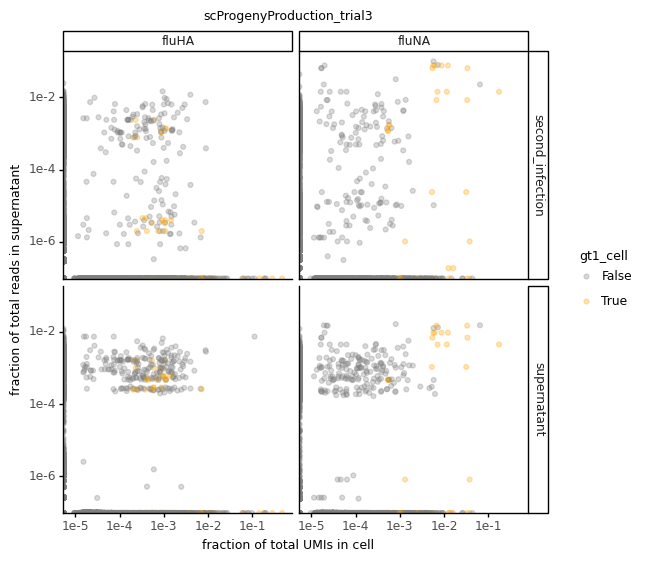

<ggplot: (8772646161427)>

In [27]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='gt1_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Viral barcodes per cell
Count the number of significant viral barcodes (above background) in each cell on each segment.

In [28]:
n_viral_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'cell_barcode',
                       'reject_uninfected'])
             ['viral_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'viral_barcode': 'n_viral_bc'}))

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_viral_bc,
    on=['infecting_viral_tag',
        'gene',
        'cell_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,count_progeny,freq_progeny,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,7457.0,4.057614e-03,NaN,NaN,NaN,False,NaN
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,2638.5,1.747121e-03,NaN,NaN,NaN,False,NaN
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN


Plot distribution of viral barcode per cell.

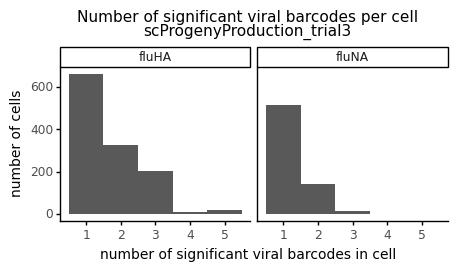

<ggplot: (8772655744964)>

In [29]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_viral_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of significant viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('number of significant viral barcodes in cell') +
       p9.ylab('number of cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label cells that have more than 1 viral barcode on a segment.

In [30]:
viral_bc_freqs['gt1_viral_bc'] = (
    viral_bc_freqs['n_viral_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,count_progeny,freq_progeny,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,7457.0,4.057614e-03,NaN,NaN,NaN,False,NaN,False
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,2638.5,1.747121e-03,NaN,NaN,NaN,False,NaN,False
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False


Plot number of cells with more than 1 significant viral barcode

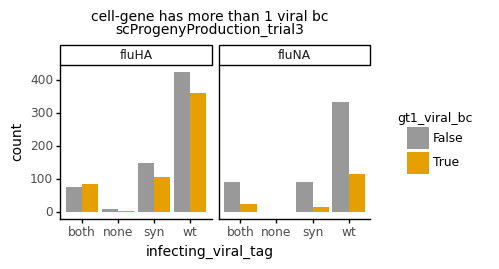

<ggplot: (8772646159764)>

In [31]:
fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infecting_viral_tag',
                               fill='gt1_viral_bc')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('cell-gene has more than 1 viral bc\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

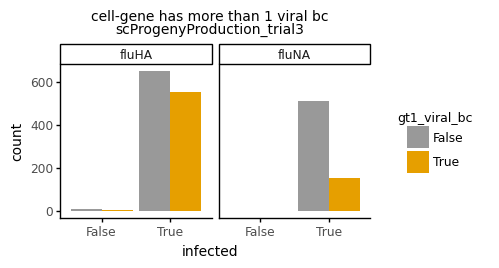

<ggplot: (8772655751900)>

In [32]:
fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infected',
                               fill='gt1_viral_bc')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('cell-gene has more than 1 viral bc\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Plot annotated highlighting cells with more than 1 significant viral barcode

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


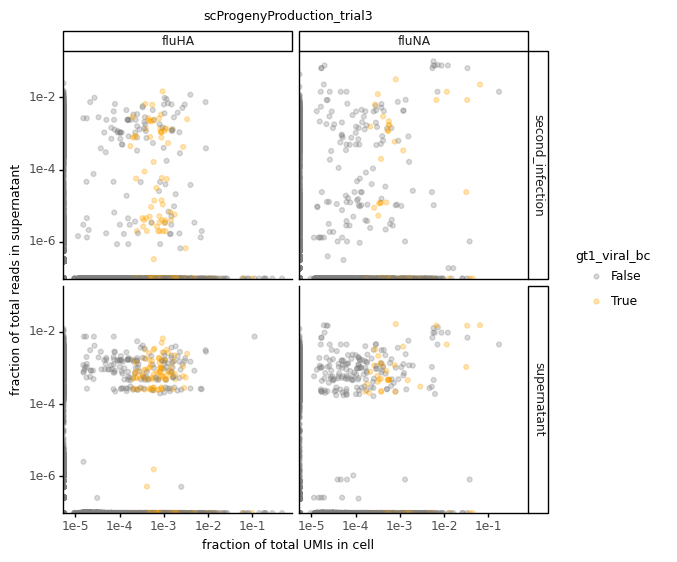

<ggplot: (8773332096988)>

In [33]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='gt1_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Viral barcode rank in cell
I will rank each viral barcode in each cell-gene. I will see what fraction of all viral barcode UMIs each viral barcode accounts for.

To do this, I will:
* Group viral barcodes by cell-gene
* Sum fraction of cell UMIs that are assigned to **significant** viral barcodes in that cell-gene
* Rank only viral barcodes **that are significant above uninfected background**

Sum all **significant** viral bc freqs for each cell-gene:

In [34]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        cell_total_frac_viral_bc_UMIs=lambda x: x
                                                .query('reject_uninfected == True')
                                                .groupby(['cell_barcode',
                                                          'gene',
                                                          'source'])
                                                ['frac_viral_bc_UMIs']
                                                .transform('sum')))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,count_progeny,freq_progeny,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,7457.0,4.057614e-03,NaN,NaN,NaN,False,NaN,False,NaN
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,2638.5,1.747121e-03,NaN,NaN,NaN,False,NaN,False,NaN
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN


Calculate proportion of total significant viral bc UMI fraction in cell-gene that is derived from each significant viral bc:

In [35]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        prop_cell_viral_bc_UMIs=lambda x: x['frac_viral_bc_UMIs'] /
                                          x['cell_total_frac_viral_bc_UMIs']))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,count_progeny,freq_progeny,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,0.0,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,0.0,0.000000e+00,39505.0,2.0,NaN,False,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,7457.0,4.057614e-03,NaN,NaN,NaN,False,NaN,False,NaN,NaN
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,2638.5,1.747121e-03,NaN,NaN,NaN,False,NaN,False,NaN,NaN
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,0.5,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN


Rank significant viral barcodes within each cell-gene:

In [36]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(viral_bc_rank=lambda x: x.groupby(['cell_barcode', 'gene', 'source'])
                                     ['prop_cell_viral_bc_UMIs']
                                     .rank('dense', ascending=False)))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,...,freq_progeny,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,...,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN,NaN
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,...,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN,NaN
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,...,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN,NaN
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,...,0.000000e+00,20969.0,1.0,NaN,False,NaN,False,NaN,NaN,NaN
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,...,0.000000e+00,39505.0,2.0,NaN,False,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,...,4.057614e-03,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,...,1.747121e-03,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,...,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,...,2.399886e-07,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN


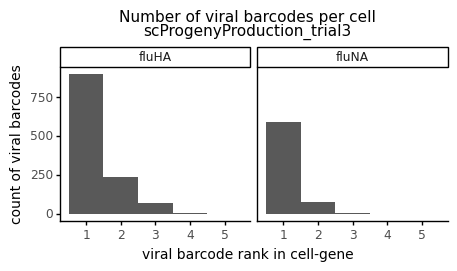

<ggplot: (8772667494584)>

In [37]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='viral_bc_rank'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('viral barcode rank in cell-gene') +
       p9.ylab('count of viral barcodes') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 27207 rows containing missing values.


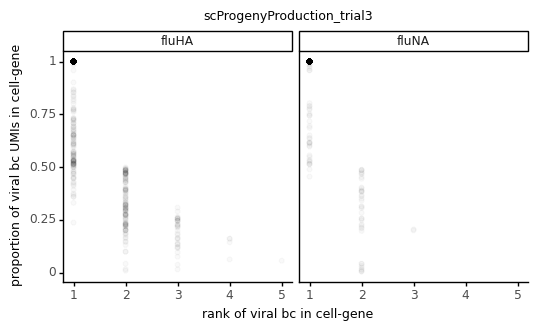

<ggplot: (8773330968736)>

In [38]:
fig = (p9.ggplot((viral_bc_freqs),
                 p9.aes(x='viral_bc_rank',
                        y='prop_cell_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.01) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='rank of viral bc in cell-gene',
               y='proportion of viral bc UMIs in cell-gene') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
      p9.scale_color_discrete(guide=False))
display(fig)

**Sanity check: viral rank vs number of viral barcodes per cell.**

The `n_significant_viral_bc_per_cell` histogram and `significant_viral_bc_rank_per_cell` histgoram do not look identical. I think some significant viral barcodes may be assigned duplicate ranks. I should check this and make sure it makes sense.

Result: Yes, sometimes low frequency viral barcodes in a cell have the same number of UMIs and get assigned identical ranks.

In [39]:
viral_bc_freqs.query('n_viral_bc > 3')

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,...,freq_progeny,total_UMIs,viral_UMIs,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank
8881,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,AAATATGAAACGATTT,81.0,0.002077,True,supernatant,...,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.252336,3.0
8882,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,AACTATCGGAGTAACA,106.0,0.002719,True,supernatant,...,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.330218,1.0
8884,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GACCTTCTGAGAAAAC,18.0,0.000462,True,supernatant,...,0.002546,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.056075,5.0
8886,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GTGAGACGTGACTTTC,20.0,0.000513,True,supernatant,...,0.000527,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.062305,4.0
8888,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GTTTCTTCTTTTTTAG,96.0,0.002462,True,supernatant,...,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.299065,2.0
8894,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,AAATATGAAACGATTT,81.0,0.002077,True,second_infection,...,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.252336,3.0
8895,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,AACTATCGGAGTAACA,106.0,0.002719,True,second_infection,...,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.330218,1.0
8897,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GACCTTCTGAGAAAAC,18.0,0.000462,True,second_infection,...,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.056075,5.0
8899,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GTGAGACGTGACTTTC,20.0,0.000513,True,second_infection,...,0.000009,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.062305,4.0
8901,ACAGAAATCTCTTGCG,True,wt,0.061243,fluHA,GTTTCTTCTTTTTTAG,96.0,0.002462,True,second_infection,...,0.000000,38992.0,2388.0,1.0,False,5.0,True,0.008232,0.299065,2.0


#### Annotate most abundant viral barcode for each cell-gene:

In [40]:
viral_bc_freqs['top_viral_bc'] = (viral_bc_freqs['viral_bc_rank'] == 1)
viral_bc_freqs['top_viral_bc'].value_counts()

False    27605
True      1490
Name: top_viral_bc, dtype: int64

#### Plot with most abundant viral barcode annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


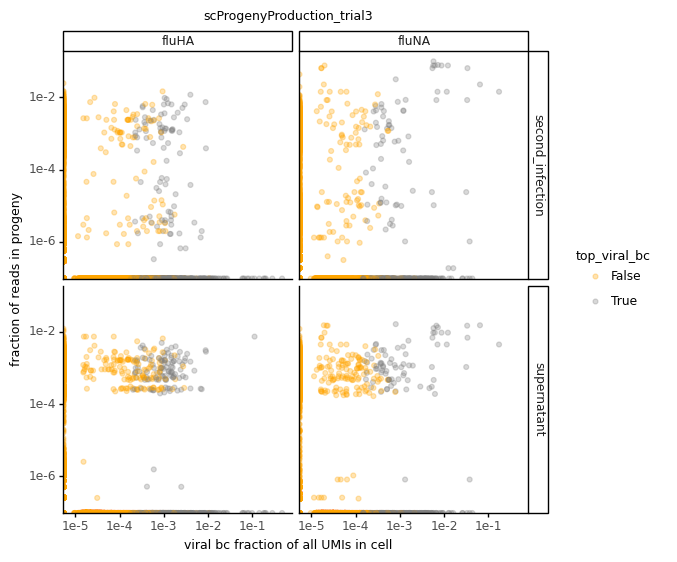

<ggplot: (8772657611005)>

In [41]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='top_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral bc fraction of all UMIs in cell',
               y='fraction of reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Viral burden
Plot the viral burden (total fraction of viral UMIs in cell) against the supernatant frequency of the most abundant viral barcode for that cell.

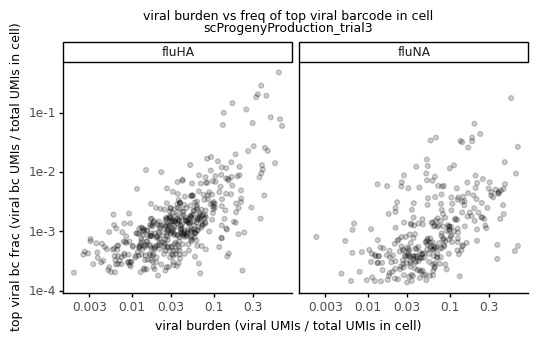

<ggplot: (8773332263196)>

In [42]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(infected == True) and'
                        '(top_viral_bc == True)'),
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral burden vs freq of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell)',
               y='top viral bc frac (viral bc UMIs / total UMIs in cell)') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

**Total UMIs per cell**

Plot the frequency of the top viral barcode as a function of total UMIs in a cell

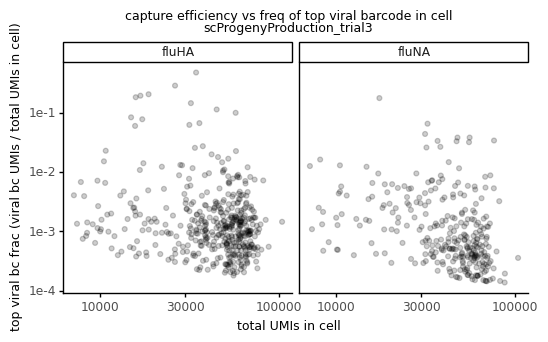

<ggplot: (8773330865442)>

In [43]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(infected == True) and'
                        '(top_viral_bc == True)'),
                 p9.aes(x='total_UMIs',
                        y='frac_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle('capture efficiency vs freq of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='total UMIs in cell',
               y='top viral bc frac (viral bc UMIs / total UMIs in cell)') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot only the top viral barcode for each cell-gene:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


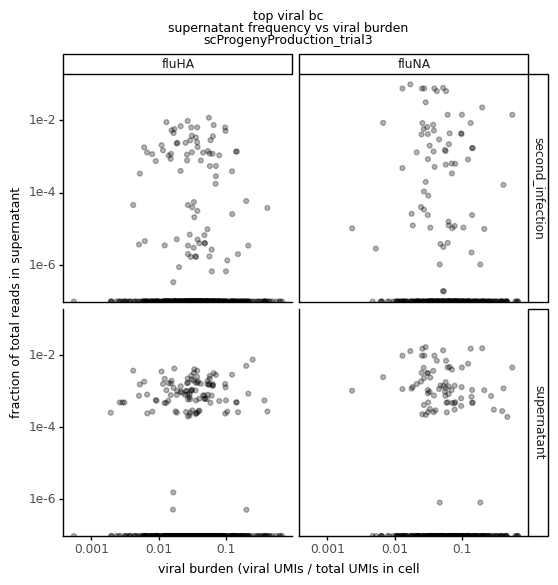

<ggplot: (8772655360148)>

In [44]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'top viral bc\n'
                   'supernatant frequency vs viral burden\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

#### Correlation of fluHA and fluNA top viral barcodes in each cell
Check to see if cells associated with high fluHA also produce high fluNA values. 

First, pivot table so supernatant frequency of top fluHA viral barcode and top fluNA viral barcode are put in column alongside cell barcode. Fill NA values with zero because this means it was not observed in sequencing, so the frequency is meaningfully zero.

**Viral barcode transcription:**

In [45]:
high_transcription = (pd.pivot_table(
    viral_bc_freqs
    .query('top_viral_bc == True '),
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag'],
    values='frac_viral_bc_UMIs',
    columns='gene')
                .reset_index()
                .fillna(0))

high_transcription

gene,cell_barcode,infected,infecting_viral_tag,fluHA,fluNA
0,AAACGAAGTACTTCCC,True,both,0.000000,0.005167
1,AAACGAAGTAGACGTG,True,wt,0.001731,0.000223
2,AAAGGATTCTGATGGT,True,syn,0.001017,0.007234
3,AAAGGGCCAGGCTACC,True,wt,0.001411,0.000470
4,AAAGGGCTCCGCACTT,True,wt,0.000218,0.000000
...,...,...,...,...,...
500,TTTAGTCGTGCTCCGA,True,wt,0.001559,0.000000
501,TTTCACAAGCCAAGCA,True,wt,0.004259,0.002974
502,TTTCGATTCAATCCAG,True,wt,0.000669,0.000000
503,TTTGATCTCGCATTGA,True,wt,0.001698,0.000000


Plot correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


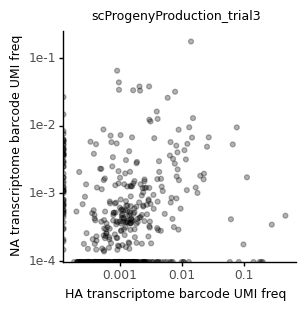

<ggplot: (8772655463759)>

In [46]:
fig = (p9.ggplot(high_transcription,
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='HA transcriptome barcode UMI freq',
               y='NA transcriptome barcode UMI freq') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

**Supernatant progeny production:**

In [47]:
high_progeny = (pd.pivot_table(
    viral_bc_freqs.query('top_viral_bc == True '),
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag',
           'source'],
    values='freq_progeny',
    columns='gene')
                .reset_index()
                .fillna(0))

high_progeny

gene,cell_barcode,infected,infecting_viral_tag,source,fluHA,fluNA
0,AAACGAAGTACTTCCC,True,both,second_infection,0.000000,0.000000
1,AAACGAAGTACTTCCC,True,both,supernatant,0.000000,0.000000
2,AAACGAAGTAGACGTG,True,wt,second_infection,0.000000,0.000000
3,AAACGAAGTAGACGTG,True,wt,supernatant,0.000287,0.000291
4,AAAGGATTCTGATGGT,True,syn,second_infection,0.000000,0.078876
...,...,...,...,...,...,...
1005,TTTCGATTCAATCCAG,True,wt,supernatant,0.000536,0.000000
1006,TTTGATCTCGCATTGA,True,wt,second_infection,0.000000,0.000000
1007,TTTGATCTCGCATTGA,True,wt,supernatant,0.000000,0.000000
1008,TTTGGAGGTATCGTTG,True,wt,second_infection,0.000000,0.000040


Plot correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


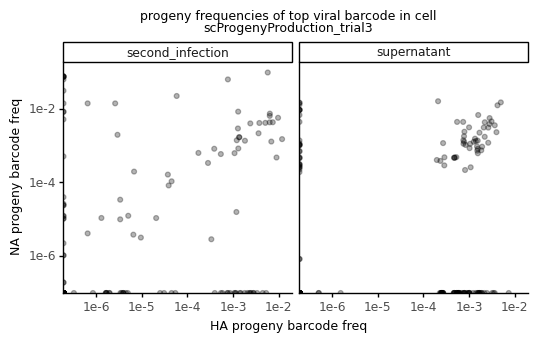

<ggplot: (8772646511424)>

In [48]:
fig = (p9.ggplot(high_progeny.
                 fillna(0),
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~source') +
       p9.ggtitle('progeny frequencies of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='HA progeny barcode freq',
               y='NA progeny barcode freq') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

## Viral gene expression

#### Bulk viral gene expression 

Simply look at the read counts assigned to each viral gene in the BAM file.

In [49]:
bam_file = 'results/aligned_fastq10x/' + expt + '/Aligned.sortedByCoord.out.bam'
bam_file

idxstats_tsv = 'results/viral_fastq10x/' + expt + 'idxstats.tsv'
print(f'The BAM file being read is {bam_file}')
print(f'The contig stats will be stored in {idxstats_tsv}')

The BAM file being read is results/aligned_fastq10x/scProgenyProduction_trial3/Aligned.sortedByCoord.out.bam
The contig stats will be stored in results/viral_fastq10x/scProgenyProduction_trial3idxstats.tsv


In [50]:
cmd = ['samtools',
       'idxstats',
       bam_file]

with open(idxstats_tsv, 'w') as f:
    subprocess.check_call(cmd, stdout=f)

with open(idxstats_tsv, 'r') as f:
    bulk_gex = pd.read_csv(f, sep='\t', header=None)
    bulk_gex.rename(columns={0:'ref_id',
                             1:'contig_len',
                             2:'mapped_reads',
                             3:'unmapped_reads'},
                    inplace=True)

bulk_gex

,ref_id,contig_len,mapped_reads,unmapped_reads
0,1,122678785,14219171,0
1,2,85426708,9434773,0
2,3,91889043,6730404,0
3,4,88276631,6284541,0
4,5,88915250,9415903,0
...,...,...,...,...
3272,fluNP,1565,344491,0
3273,fluNA,1735,95284,0
3274,fluM,1027,701982,0
3275,fluNS,890,555038,0


In [51]:
bulk_gex.query(f'ref_id in {viral_genes}')

,ref_id,contig_len,mapped_reads,unmapped_reads
3268,fluPB2,2341,28552,0
3269,fluPB1,2341,86853,0
3270,fluPA,2233,9879,0
3271,fluHA,2035,226522,0
3272,fluNP,1565,344491,0
3273,fluNA,1735,95284,0
3274,fluM,1027,701982,0
3275,fluNS,890,555038,0


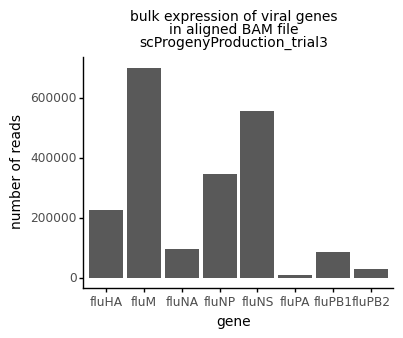

<ggplot: (8772645998294)>

In [52]:
fig = (p9.ggplot((bulk_gex.query(f'ref_id in {viral_genes}')),
                  p9.aes(x='factor(ref_id)',
                         y='mapped_reads')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('bulk expression of viral genes\n'
                         'in aligned BAM file\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of reads') +
              p9.theme(figure_size=(4, 3),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_x_discrete())
display(fig)

#### Viral genes in each cell
Extract the UMI counts for each viral gene in each cell from `adata.obs`

In [53]:
#### Viral genes in each cell
viral_gene_expression = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                   .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            fluPB2=numpy.sum(adata[adata.obs['gene'] == 'fluPB2', ]
                             .X, axis=0).A1.astype(int),
            fluPB1=numpy.sum(adata[adata.obs['gene'] == 'fluPB1', ]
                             .X, axis=0).A1.astype(int),
            fluPA=numpy.sum(adata[adata.obs['gene'] == 'fluPA', ]
                             .X, axis=0).A1.astype(int),
            fluHA=numpy.sum(adata[adata.obs['gene'] == 'fluHA', ]
                             .X, axis=0).A1.astype(int),
            fluNP=numpy.sum(adata[adata.obs['gene'] == 'fluNP', ]
                             .X, axis=0).A1.astype(int),
            fluNA=numpy.sum(adata[adata.obs['gene'] == 'fluNA', ]
                             .X, axis=0).A1.astype(int),
            fluM=numpy.sum(adata[adata.obs['gene'] == 'fluM', ]
                             .X, axis=0).A1.astype(int),
            fluNS=numpy.sum(adata[adata.obs['gene'] == 'fluNS', ]
                             .X, axis=0).A1.astype(int),
           )
)

viral_gene_expression

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,total_UMIs,viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS
0,AAACCCAGTAACAAGT,20969,1,0,0,0,0,0,0,1,0
1,AAACCCATCATTGCTT,39505,2,1,0,0,1,0,0,0,0
2,AAACGAAAGATGTTGA,49137,10,0,0,0,0,0,0,6,4
3,AAACGAAGTACTTCCC,25547,11452,78,232,8,1,1780,192,6276,2885
4,AAACGAAGTAGACGTG,53719,2155,2,17,4,142,286,13,708,983
...,...,...,...,...,...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,27511,3,0,0,0,0,1,0,1,1
3364,TTTGATCTCGCATTGA,73596,4648,13,46,3,257,526,496,2251,1056
3365,TTTGGAGAGTTGCCTA,28413,2,0,0,0,0,1,0,1,0
3366,TTTGGAGGTATCGTTG,65134,1598,5,29,2,39,188,17,750,568


Bring in infection status and tag information:

In [54]:
viral_gene_expression = pd.merge(
    left=viral_gene_expression,
    right=(viral_bc_freqs
           .query('cell_barcode.notnull()',
                  engine='python')
           [['cell_barcode',
             'infected',
             'infecting_viral_tag']]
           .drop_duplicates()),
    on='cell_barcode',
    how='left',
    validate='one_to_one'
    )

viral_gene_expression

,cell_barcode,total_UMIs,viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS,infected,infecting_viral_tag
0,AAACCCAGTAACAAGT,20969,1,0,0,0,0,0,0,1,0,False,none
1,AAACCCATCATTGCTT,39505,2,1,0,0,1,0,0,0,0,False,none
2,AAACGAAAGATGTTGA,49137,10,0,0,0,0,0,0,6,4,False,none
3,AAACGAAGTACTTCCC,25547,11452,78,232,8,1,1780,192,6276,2885,True,both
4,AAACGAAGTAGACGTG,53719,2155,2,17,4,142,286,13,708,983,True,wt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,27511,3,0,0,0,0,1,0,1,1,False,none
3364,TTTGATCTCGCATTGA,73596,4648,13,46,3,257,526,496,2251,1056,True,wt
3365,TTTGGAGAGTTGCCTA,28413,2,0,0,0,0,1,0,1,0,False,none
3366,TTTGGAGGTATCGTTG,65134,1598,5,29,2,39,188,17,750,568,True,wt


Pivot the table so that gene is a column, and the UMI counts for each gene for each cell is a row

In [55]:
viral_gene_expression_long = viral_gene_expression.melt(
    id_vars=['cell_barcode',
             'infected',
             'infecting_viral_tag',
             'total_UMIs',
             'viral_UMIs'],
    var_name='gene',
    value_name='gene_UMIs'
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2
...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568


Check that total number of rows is = total number of cells * total number of genes, for both infected and uninfected:

In [56]:
assert (len(viral_gene_expression_long) ==
        len(viral_gene_expression_long['cell_barcode'].drop_duplicates()) *
        len(viral_genes)), "not 8 genes for every cell"

Check that the extracted gene_UMIs sum to the total viral UMIs for each cell:

In [57]:
pd.testing.assert_frame_equal(
    (viral_gene_expression_long[['cell_barcode',
                                 'viral_UMIs']]
     .drop_duplicates()),
    (viral_gene_expression_long
     .groupby('cell_barcode')
     ['gene_UMIs']
     .sum()
     .to_frame()
     .reset_index()
     .rename(columns={'gene_UMIs': 'viral_UMIs'})),
    check_names=False,
    check_index_type=False
)

Calculate the fraction of all UMIs assigned to each viral gene individually, and in aggregate:

In [58]:
viral_gene_expression_long['frac_viral_UMIs'] = (
    viral_gene_expression_long['viral_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long['frac_gene_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78,0.448272,0.003053
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2,0.040116,0.000037
...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1,0.000109,0.000036
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056,0.063156,0.014349
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720


Plot distribution of absolute UMI counts for each gene:

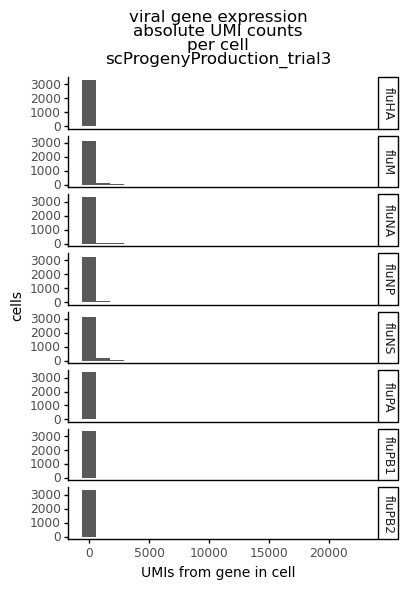

<ggplot: (8772667439990)>

In [59]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 16097 rows containing non-finite values.


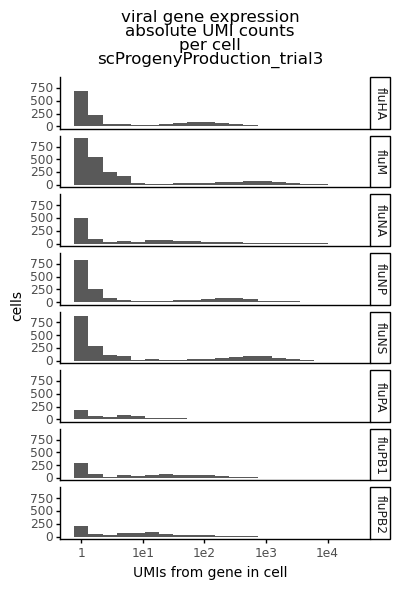

<ggplot: (8773332196250)>

In [60]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot distribution of fraction of UMIs from each viral gene:

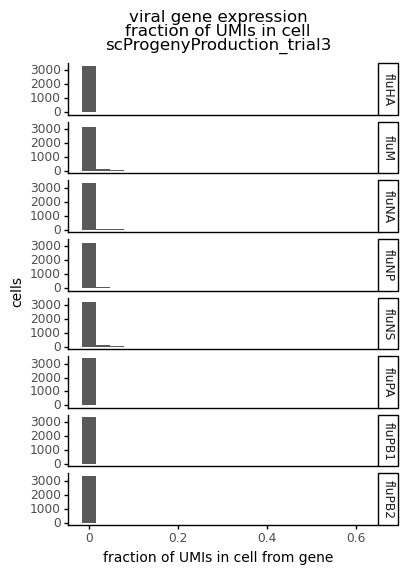

<ggplot: (8772657687339)>

In [61]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 16097 rows containing non-finite values.


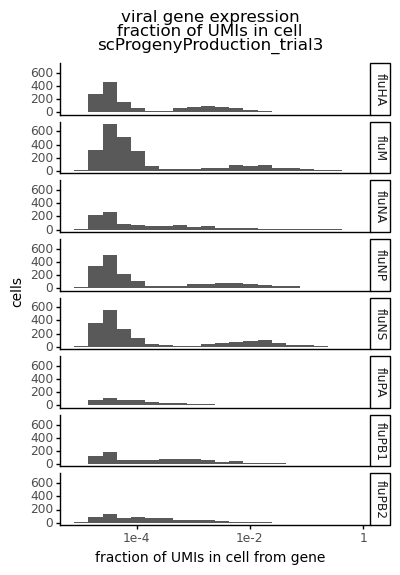

<ggplot: (8773332170352)>

In [62]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

What is the relationship between absolute UMI counts and fraction of all UMIs in cell for each gene?

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


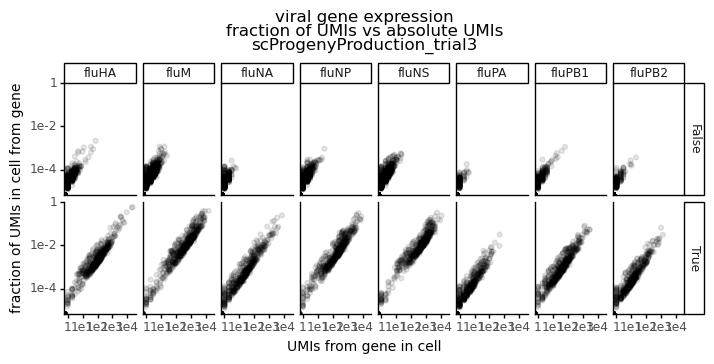

<ggplot: (8772646235191)>

In [63]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs',
                        y='frac_gene_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs vs absolute UMIs\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='fraction of UMIs in cell from gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(8, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Distribution of viral gene expression in infected and **uninfected** cells:

**N.b.** Plot 0 values on far left of axis, 100-fold lower than lowest real value:

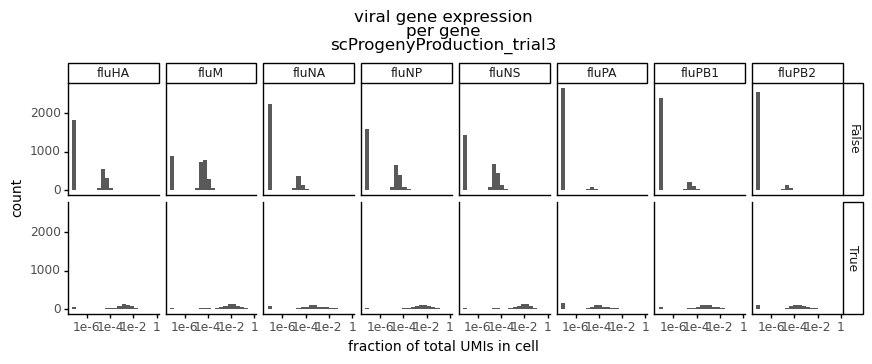

<ggplot: (8773330967727)>

In [64]:
zero_pseudocount = (min(viral_gene_expression_long
                        .query('frac_gene_UMIs > 0')
                        ['frac_gene_UMIs']) /
                    100)
zero_pseudocount

fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 16097 rows containing non-finite values.


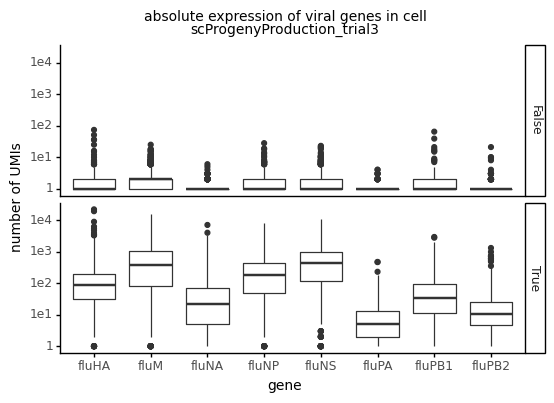

<ggplot: (8773330893990)>

In [65]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('absolute expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of UMIs') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 16097 rows containing non-finite values.


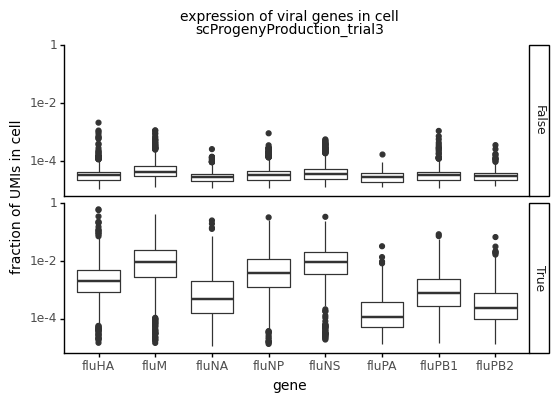

<ggplot: (8773330815621)>

In [66]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='frac_gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('fraction of UMIs in cell') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

#### Proportion of viral UMIs from each gene

Next, within each cell, I will calculate the proportion of all viral UMIs derived from each gene. 

In [67]:
viral_gene_expression_long['prop_viral_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['viral_UMIs']
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.000000
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025,0.500000
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000,0.000000
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78,0.448272,0.003053,0.006811
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2,0.040116,0.000037,0.000928
...,...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1,0.000109,0.000036,0.333333
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056,0.063156,0.014349,0.227194
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000,0.000000
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720,0.355444


Check that the proportion sums to 1 for every cell:

In [68]:
test_prop_sum_df = pd.merge(
    left=viral_gene_expression_long,
    right=(viral_gene_expression_long
           .groupby('cell_barcode')
           ['prop_viral_UMIs']
           .sum()
           .round(4)),
    suffixes=[None,'_sum'],
    on='cell_barcode',
)

test_prop_sum_df['sum_OK'] = test_prop_sum_df.apply(
    lambda x: (x['prop_viral_UMIs_sum'] == 1) or (x['viral_UMIs'] == 0),
    axis=1)
                              
assert (test_prop_sum_df['sum_OK'] == True).all(), \
    "problem summing viral gene proportions"

test_prop_sum_df


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs,prop_viral_UMIs_sum,sum_OK
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.00,1.0,True
1,AAACCCAGTAACAAGT,False,none,20969,1,fluPB1,0,0.000048,0.000000,0.00,1.0,True
2,AAACCCAGTAACAAGT,False,none,20969,1,fluPA,0,0.000048,0.000000,0.00,1.0,True
3,AAACCCAGTAACAAGT,False,none,20969,1,fluHA,0,0.000048,0.000000,0.00,1.0,True
4,AAACCCAGTAACAAGT,False,none,20969,1,fluNP,0,0.000048,0.000000,0.00,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
26939,TTTGTTGAGTGCAGCA,False,none,58559,4,fluHA,1,0.000068,0.000017,0.25,1.0,True
26940,TTTGTTGAGTGCAGCA,False,none,58559,4,fluNP,0,0.000068,0.000000,0.00,1.0,True
26941,TTTGTTGAGTGCAGCA,False,none,58559,4,fluNA,0,0.000068,0.000000,0.00,1.0,True
26942,TTTGTTGAGTGCAGCA,False,none,58559,4,fluM,1,0.000068,0.000017,0.25,1.0,True


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 1672 rows containing non-finite values.


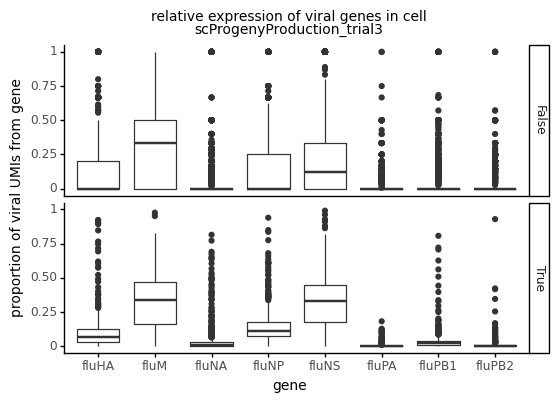

<ggplot: (8773330822672)>

In [69]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='prop_viral_UMIs')) +
              p9.geom_boxplot() +
              p9.ggtitle('relative expression of viral genes in cell\n'
                         f'{expt}') +
              p9.facet_grid('infected~') +
              p9.xlab('gene') +
              p9.ylab('proportion of viral UMIs from gene') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

### Call presence/absence of viral genes

Next I will extract the 90 percentile value from the uninfected cells. We were very conservative in calling cells as infected (likely there are some infected cells in the population labelled "uninfected"). A priori, we expect most infected cells to express most viral genes. So we can be more lenient in what we use as a cutoff in calling a gene present.

For low expressing genes (e.g. the polymerase complex), the 95th percentile is a value of 0, and this threshold does not work well. Instead, we will simply call genes without **any** UMIs as absent, and genes with at least 1 UMI as present.  In some previous analyses (e.g. [Russel et al. 2018](https://elifesciences.org/articles/32303)) a single transcript was used to call the presence of a gene in infected cells.

In [70]:
limit_percentile = 0.9
limit = dict()

for gene in viral_genes:
    limit[gene] = (viral_gene_expression_long
                   .query('(infecting_viral_tag == "none") '
                          f'and (gene == "{gene}")')
                   ['frac_gene_UMIs']
                   .quantile(limit_percentile))

limit = pd.DataFrame.from_dict(limit, orient='index')
limit = limit.reset_index()
limit = limit.rename(columns={0: 'limit_frac',
                              'index': 'gene'})

limit

,gene,limit_frac
0,fluPB2,0.000000
1,fluPB1,0.000022
2,fluPA,0.000000
3,fluHA,0.000042
4,fluNA,0.000028
5,fluNP,0.000049
6,fluM,0.000090
7,fluNS,0.000063


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 16097 rows containing non-finite values.


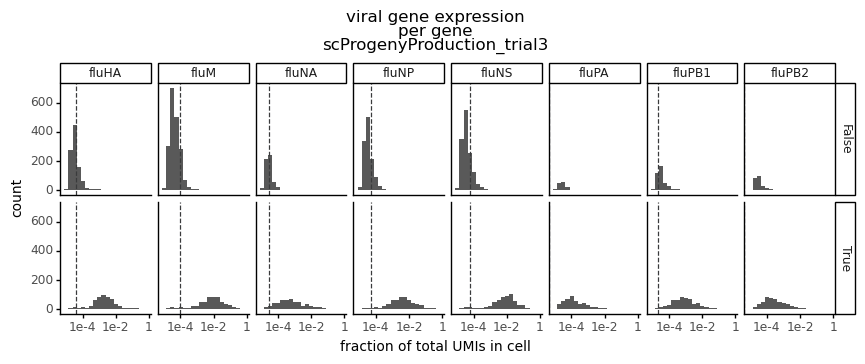

<ggplot: (8772646004252)>

In [71]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.geom_vline(limit,
                     p9.aes(xintercept='limit_frac'),
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

Build a poisson distribution around this value. I will perform a statistical test to see if the value seen for each gene in infected cells falls within this distribution or rejects the null hypothesis.

Now calculate the expected number of UMIs for each gene using this upper bound limit. For every cell and gene, I will simply multiply the total number of UMIs by this limit value.

In [72]:
viral_gene_expression_long = pd.merge(
    left=viral_gene_expression_long,
    right=limit,
    on=['gene'],
    how='left'
    )

Calculate the expected number of UMIs corresponding to this limit fraction for each cell.

In [73]:
viral_gene_expression_long['limit_UMIs'] = (viral_gene_expression_long['total_UMIs'] *
                                            viral_gene_expression_long['limit_frac'])
viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs,limit_frac,limit_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.000000,0.000000,0.000000
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025,0.500000,0.000000,0.000000
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000,0.000000,0.000000,0.000000
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78,0.448272,0.003053,0.006811,0.000000,0.000000
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2,0.040116,0.000037,0.000928,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1,0.000109,0.000036,0.333333,0.000063,1.738910
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056,0.063156,0.014349,0.227194,0.000063,4.651841
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000,0.000000,0.000063,1.795923
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720,0.355444,0.000063,4.116977


Calculate the p-value that a gene is present above the background distribution (poisson distribution with mu = `limit_UMIs`).

A few notes on how this is calculated:  
* We want the probability of yielding greater than **or equal to** the observed number of UMIs for each gene.
* `P = scipy.stats.poisson.cdf(k = x, mu = l)` returns the probability of yielding less than or equal to the observed number of UMIs (`x`) for each gene.
* To get the probability of yielding **greater than** `x`, we simply take `1 - P`.
* Because the Poisson distribution functions on integers, to get the probability of yielding a value greater than **or equal to**, we simply calcuate P on `x - 1`.

The final expression to return the **probability of yielding greater than or equal to the observed number of UMIs** is:  
`P = 1 - scipy.stats.poisson.cdf(k = (x-1), mu = l)`

In [74]:
p_cutoff = 0.05

viral_gene_expression_long['null_P'] = (
    1 - scipy.stats.poisson.cdf(
        k=(viral_gene_expression_long['gene_UMIs']-1),
        mu=viral_gene_expression_long['limit_UMIs']))

viral_gene_expression_long['gene_present'] = (
    (viral_gene_expression_long['gene_UMIs'] > 0)
    & (viral_gene_expression_long['null_P'] < p_cutoff))

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs,limit_frac,limit_UMIs,null_P,gene_present
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.000000,0.000000,0.000000,1.000000,False
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025,0.500000,0.000000,0.000000,0.000000,True
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000,0.000000,0.000000,0.000000,1.000000,False
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78,0.448272,0.003053,0.006811,0.000000,0.000000,0.000000,True
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2,0.040116,0.000037,0.000928,0.000000,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1,0.000109,0.000036,0.333333,0.000063,1.738910,0.824288,False
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056,0.063156,0.014349,0.227194,0.000063,4.651841,0.000000,True
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000,0.000000,0.000063,1.795923,1.000000,False
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720,0.355444,0.000063,4.116977,0.000000,True


Plot the proportion of viral UMIs from each gene against the p value for every cell:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


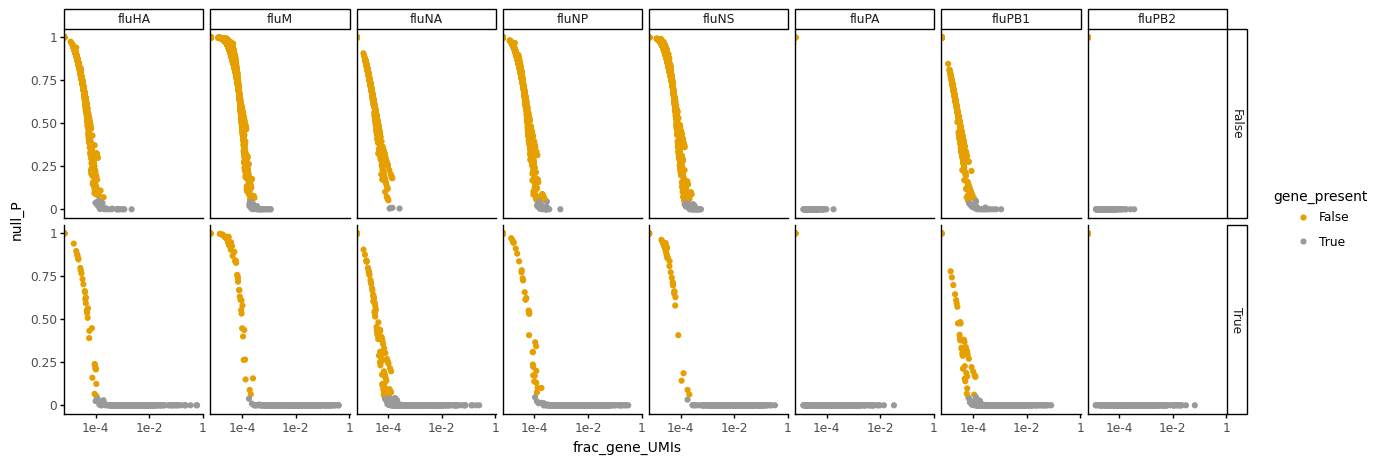

<ggplot: (8773330810293)>

In [75]:
fig = (p9.ggplot((viral_gene_expression_long),
                 p9.aes(x='frac_gene_UMIs',
                        y='null_P',
                        color='gene_present')) +
       p9.geom_point() +
       p9.facet_grid('infected~gene') +
       p9.theme(figure_size=(15, 5),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1],CBPALETTE[0]]) +
       p9.scale_x_log10()
       )
display(fig)

Color the proportion histogram by present/absent call:

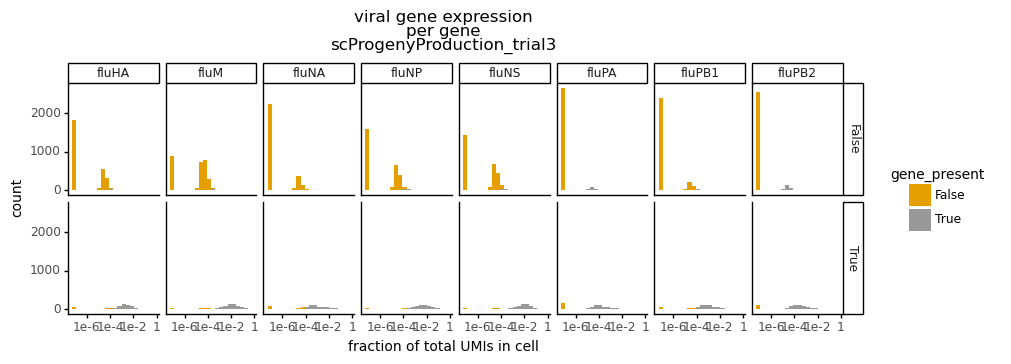

<ggplot: (8772646383074)>

In [76]:
fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs',
                        fill='gene_present')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10() +
       p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]])
       )
display(fig)

In general, expression of all viral genes correlates with one another.  Let's check to see if we are correctly excluding viral genes that violate this correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


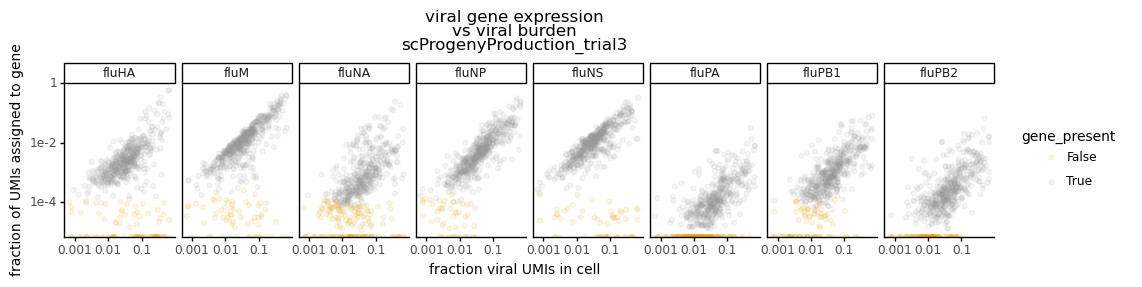

<ggplot: (8772655364316)>

In [77]:
fig = (p9.ggplot((viral_gene_expression_long
                  .query('infected == True')),
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_gene_UMIs',
                        color='gene_present')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'vs viral burden\n'
                  f'{expt}') +
       p9.labs(x='fraction viral UMIs in cell',
               y='fraction of UMIs assigned to gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(12, 2),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

Annotate the fraction of cells that have each viral gene:

In [78]:
has_gene = pd.DataFrame(
    viral_gene_expression_long
    .query('infecting_viral_tag != "both"')
    .groupby(['infected',
              'gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='prop_cells'))

has_gene

,infected,gene,gene_present,prop_cells
0,False,fluHA,False,0.988873
1,False,fluHA,True,0.011127
2,False,fluM,False,0.986001
3,False,fluM,True,0.013999
4,False,fluNA,False,0.998564
5,False,fluNA,True,0.001436
6,False,fluNP,False,0.988514
7,False,fluNP,True,0.011486
8,False,fluNS,False,0.982053
9,False,fluNS,True,0.017947


Plot this fraction for each gene and infecting viral tag:

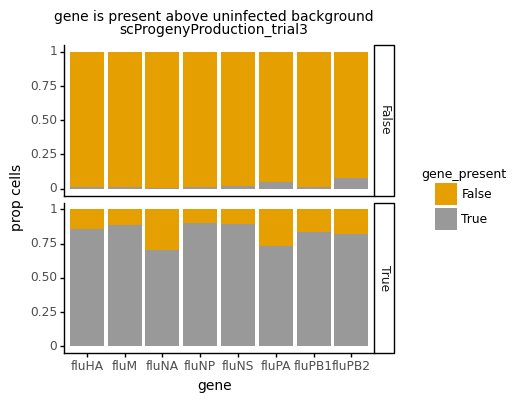

<ggplot: (8772646851729)>

In [79]:
fig = (p9.ggplot((has_gene),
                  p9.aes(x='gene',
                         y='prop_cells',
                         fill='gene_present')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('gene is present above uninfected background\n'
                         f'{expt}') +
              p9.ylab('prop cells') +
              p9.facet_grid('infected~') +
              p9.theme(figure_size=(4, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

Tabulate the number of viral genes present in each cell

In [80]:
n_viral_genes = (pd.pivot_table(
    viral_gene_expression_long,
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag',
           'total_UMIs'],
    values='gene_present',
    aggfunc=numpy.sum)
                 .reset_index()
                 .rename(columns={'gene_present':'n_viral_genes_present'}))

n_viral_genes

,cell_barcode,infected,infecting_viral_tag,total_UMIs,n_viral_genes_present
0,AAACCCAGTAACAAGT,False,none,20969,0
1,AAACCCATCATTGCTT,False,none,39505,1
2,AAACGAAAGATGTTGA,False,none,49137,0
3,AAACGAAGTACTTCCC,True,both,25547,7
4,AAACGAAGTAGACGTG,True,wt,53719,8
...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none,27511,0
3364,TTTGATCTCGCATTGA,True,wt,73596,8
3365,TTTGGAGAGTTGCCTA,False,none,28413,0
3366,TTTGGAGGTATCGTTG,True,wt,65134,8


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


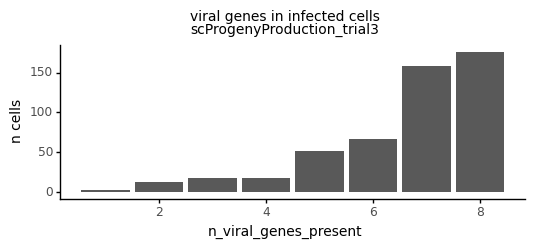

<ggplot: (8772655563430)>

In [81]:
fig = (p9.ggplot((n_viral_genes
                  .query('infected == True and '
                         'infecting_viral_tag != "both"')),
                  p9.aes(x='n_viral_genes_present')) +
              p9.geom_bar(stat='count') +
              p9.ggtitle('viral genes in infected cells\n'
                         f'{expt}') +
              p9.ylab('n cells') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Add this information to viral_bc_freqs dataframe

In [82]:
viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=n_viral_genes,
    on=['cell_barcode',
        'infected',
        'infecting_viral_tag'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,...,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank,top_viral_bc,total_UMIs_y,n_viral_genes_present
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,...,NaN,False,NaN,False,NaN,NaN,NaN,False,20969.0,0.0
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,...,NaN,False,NaN,False,NaN,NaN,NaN,False,20969.0,0.0
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,...,NaN,False,NaN,False,NaN,NaN,NaN,False,20969.0,0.0
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,...,NaN,False,NaN,False,NaN,NaN,NaN,False,20969.0,0.0
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,...,NaN,False,NaN,False,NaN,NaN,NaN,False,39505.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,False,NaN,NaN,NaN,False,NaN,NaN


Plot the distribution of viral burden in infected cells binned by number of viral genes present.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


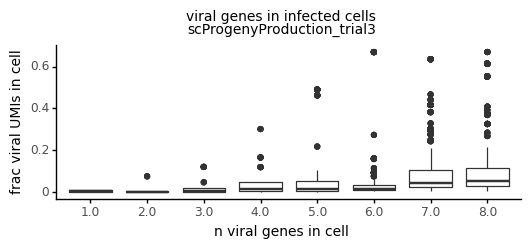

<ggplot: (8773330987647)>

In [83]:
fig = (p9.ggplot((viral_bc_freqs
                  .query('infected == True and '
                         'infecting_viral_tag != "both"')),
                  p9.aes(x='factor(n_viral_genes_present)',
                         y='frac_viral_UMIs')) +
              p9.geom_boxplot() +
              p9.ggtitle('viral genes in infected cells\n'
                         f'{expt}') +
              p9.xlab('n viral genes in cell') +
              p9.ylab('frac viral UMIs in cell') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Color the transcription-progeny plot by the number of viral genes present

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


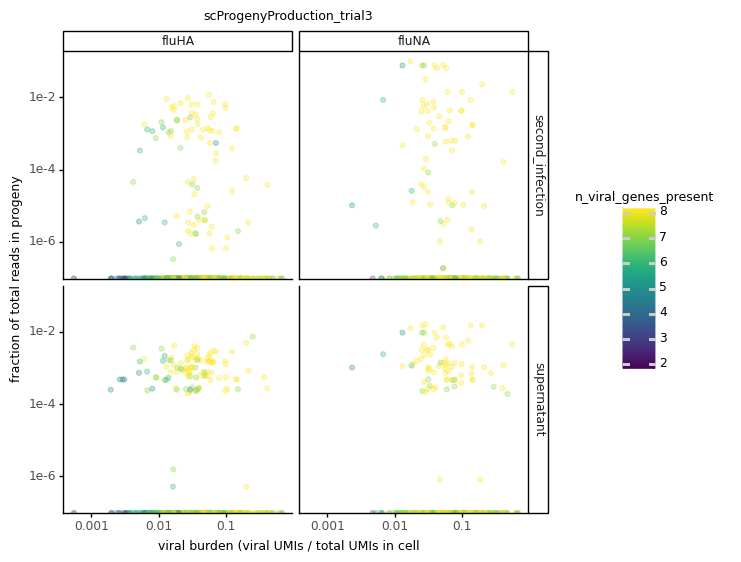

<ggplot: (8772657552391)>

In [84]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny',
                        color='n_viral_genes_present')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)


### Viral gene presence/absence as a function of other metrics

Plot relationship between n viral genes and viral burden

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 10715 rows containing missing values.


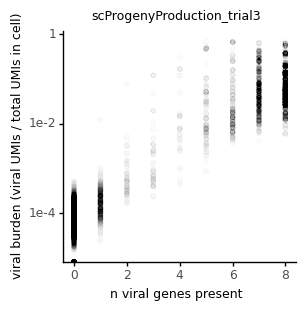

<ggplot: (8773332155212)>

In [85]:
fig = (p9.ggplot(viral_bc_freqs,
                 p9.aes(x='n_viral_genes_present',
                        y='frac_viral_UMIs')) +
       p9.geom_point(alpha=0.005) +
       p9.ggtitle(f'{expt}') +
       p9.scale_y_log10() +
       p9.labs(x='n viral genes present',
               y='viral burden (viral UMIs / total UMIs in cell)') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot relationship between n viral genes and viral progeny production in sup

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


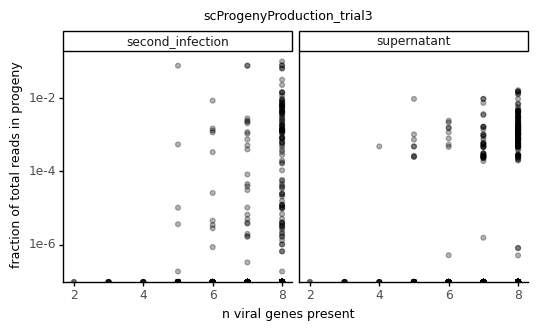

<ggplot: (8772646293285)>

In [86]:
fig = (p9.ggplot((viral_bc_freqs
                 .query('top_viral_bc == True')),
                 p9.aes(x='n_viral_genes_present',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~source') +
       p9.ggtitle(f'{expt}') +
       p9.scale_y_log10() +
       p9.labs(x='n viral genes present',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Check to see how viral gene presence/absence relates to the total number of UMIs generated for that cell to assess capture:

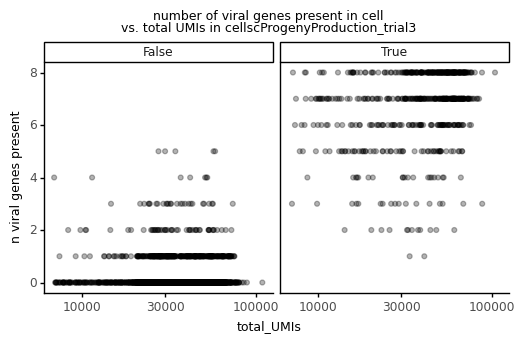

<ggplot: (8773330796487)>

In [87]:
fig = (p9.ggplot(n_viral_genes,
                 p9.aes(x='total_UMIs',
                        y='n_viral_genes_present')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~infected') +
       p9.ggtitle(f'number of viral genes present in cell\n'
                  f'vs. total UMIs in cell'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.labs(x='total_UMIs',
               y='n viral genes present') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

### All viral genes
Annotate cells that have all genes:

In [88]:
n_viral_genes['all_genes'] = (n_viral_genes['n_viral_genes_present'] == 8)
n_viral_genes

,cell_barcode,infected,infecting_viral_tag,total_UMIs,n_viral_genes_present,all_genes
0,AAACCCAGTAACAAGT,False,none,20969,0,False
1,AAACCCATCATTGCTT,False,none,39505,1,False
2,AAACGAAAGATGTTGA,False,none,49137,0,False
3,AAACGAAGTACTTCCC,True,both,25547,7,False
4,AAACGAAGTAGACGTG,True,wt,53719,8,True
...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none,27511,0,False
3364,TTTGATCTCGCATTGA,True,wt,73596,8,True
3365,TTTGGAGAGTTGCCTA,False,none,28413,0,False
3366,TTTGGAGGTATCGTTG,True,wt,65134,8,True


Add this info to viral_bc_freqs

In [89]:
viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=n_viral_genes,
    on=['cell_barcode',
        'infected',
        'infecting_viral_tag',
        'n_viral_genes_present'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,...,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank,top_viral_bc,total_UMIs_y,n_viral_genes_present,total_UMIs,all_genes
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,...,NaN,False,NaN,NaN,NaN,False,20969.0,0.0,20969.0,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,...,NaN,False,NaN,NaN,NaN,False,20969.0,0.0,20969.0,False
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,...,NaN,False,NaN,NaN,NaN,False,20969.0,0.0,20969.0,False
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,...,NaN,False,NaN,NaN,NaN,False,20969.0,0.0,20969.0,False
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,...,NaN,False,NaN,NaN,NaN,False,39505.0,1.0,39505.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29090,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
29091,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
29092,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
29093,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN


Plot transcription vs progeny, annotated by complete genome:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


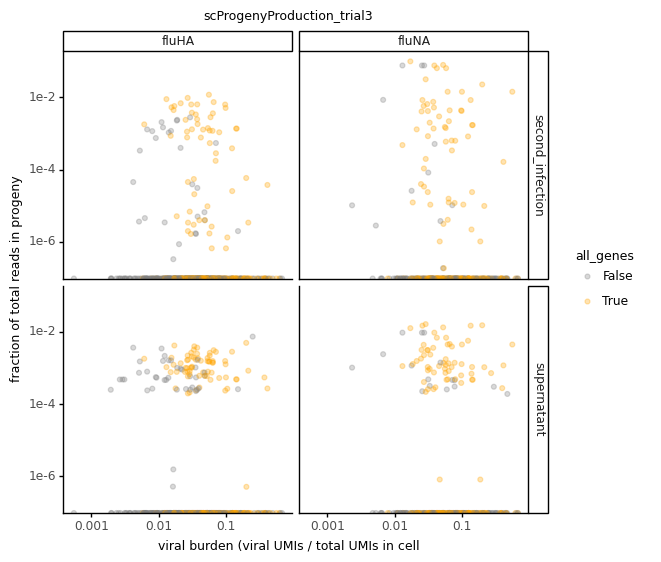

<ggplot: (8772646004336)>

In [90]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny',
                        color='all_genes')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Annotate whether cells contribute progeny
If you simply take `freq_progeny > 0`, the result will be on a per viral bc basis.

We want to define this on a per cell-gene basis and a per cell basis. Progeny contribution is first defined on a per cell-gene basis (fluHA or fluNA). Then, on a per cell basis (cell barcode with any progeny on either fluHA or fluNA).

All contribute_progeny calls are made separately for second infection and supernatant sources.

In [91]:
contribute_progeny_df = (
    viral_bc_freqs[['cell_barcode',
                    'gene',
                    'source',
                    'viral_barcode',
                    'count_progeny']])

# sum progeny for gene and source
contribute_progeny_df = pd.merge(
    left=contribute_progeny_df,
    right=(contribute_progeny_df
           .groupby(['cell_barcode',
                     'source',
                     'gene'])
           ['count_progeny']
           .sum()
           .reset_index()
           .rename(columns={'count_progeny':'gene_source_progeny_sum'})),
    on=['cell_barcode',
        'source',
        'gene'],
    how='left')

contribute_progeny_df['contributes_gene_source_progeny'] = (
    contribute_progeny_df['gene_source_progeny_sum'] > 0
)

# sum progeny for source
contribute_progeny_df = pd.merge(
    left=contribute_progeny_df,
    right=(contribute_progeny_df
           .groupby(['cell_barcode',
                     'source'])
           ['count_progeny']
           .sum()
           .reset_index()
           .rename(columns={'count_progeny':'source_progeny_sum'})),
    on=['cell_barcode',
        'source'],
    how='left')

contribute_progeny_df['contributes_source_progeny'] = (
    contribute_progeny_df['source_progeny_sum'] > 0
)

contribute_progeny_df

,cell_barcode,gene,source,viral_barcode,count_progeny,gene_source_progeny_sum,contributes_gene_source_progeny,source_progeny_sum,contributes_source_progeny
0,AAACCCAGTAACAAGT,fluHA,supernatant,NaN,0.0,0.0,False,0.0,False
1,AAACCCAGTAACAAGT,fluNA,supernatant,NaN,0.0,0.0,False,0.0,False
2,AAACCCAGTAACAAGT,fluHA,second_infection,NaN,0.0,0.0,False,0.0,False
3,AAACCCAGTAACAAGT,fluNA,second_infection,NaN,0.0,0.0,False,0.0,False
4,AAACCCATCATTGCTT,fluHA,supernatant,NaN,0.0,0.0,False,0.0,False
...,...,...,...,...,...,...,...,...,...
29090,NaN,fluNA,supernatant,TTTTCGGGATCATTGC,7457.0,NaN,False,NaN,False
29091,NaN,fluNA,supernatant,TTTTCGTGAAAAGAGA,2638.5,NaN,False,NaN,False
29092,NaN,fluNA,supernatant,TTTTGGTTGTGAGGTG,0.5,NaN,False,NaN,False
29093,NaN,fluNA,supernatant,TTTTGTTACATCATCT,0.5,NaN,False,NaN,False


In [92]:
contribute_progeny_df.query('cell_barcode == "TTTGGAGGTATCGTTG"')

,cell_barcode,gene,source,viral_barcode,count_progeny,gene_source_progeny_sum,contributes_gene_source_progeny,source_progeny_sum,contributes_source_progeny
18374,TTTGGAGGTATCGTTG,fluHA,supernatant,AGTAAACTTCCTCGCG,1511.5,1511.5,True,4832.0,True
18375,TTTGGAGGTATCGTTG,fluHA,supernatant,ATGAAAATTCCGAGCG,0.0,1511.5,True,4832.0,True
18376,TTTGGAGGTATCGTTG,fluNA,supernatant,ACATCTTATTTACACG,3320.5,3320.5,True,4832.0,True
18377,TTTGGAGGTATCGTTG,fluHA,second_infection,AGTAAACTTCCTCGCG,0.0,0.0,False,50.0,True
18378,TTTGGAGGTATCGTTG,fluHA,second_infection,ATGAAAATTCCGAGCG,0.0,0.0,False,50.0,True
18379,TTTGGAGGTATCGTTG,fluNA,second_infection,ACATCTTATTTACACG,50.0,50.0,True,50.0,True


Integrate this data back into `viral_bc_freqs`

In [93]:
viral_bc_freqs = (pd.merge(
                    left=viral_bc_freqs,
                    right=contribute_progeny_df,
                    on=['cell_barcode',
                        'gene',
                        'source',
                        'viral_barcode',
                        'count_progeny'],
                    how='left')
                  .drop_duplicates())
viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,source,...,viral_bc_rank,top_viral_bc,total_UMIs_y,n_viral_genes_present,total_UMIs,all_genes,gene_source_progeny_sum,contributes_gene_source_progeny,source_progeny_sum,contributes_source_progeny
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,supernatant,...,NaN,False,20969.0,0.0,20969.0,False,0.0,False,0.0,False
1,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,supernatant,...,NaN,False,20969.0,0.0,20969.0,False,0.0,False,0.0,False
2,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,second_infection,...,NaN,False,20969.0,0.0,20969.0,False,0.0,False,0.0,False
3,AAACCCAGTAACAAGT,False,none,0.000048,fluNA,NaN,0.0,0.0,False,second_infection,...,NaN,False,20969.0,0.0,20969.0,False,0.0,False,0.0,False
4,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,supernatant,...,NaN,False,39505.0,1.0,39505.0,False,0.0,False,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29124,NaN,NaN,wt,NaN,fluNA,TTTTCGGGATCATTGC,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False
29125,NaN,NaN,wt,NaN,fluNA,TTTTCGTGAAAAGAGA,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False
29126,NaN,NaN,wt,NaN,fluNA,TTTTGGTTGTGAGGTG,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False
29127,NaN,NaN,wt,NaN,fluNA,TTTTGTTACATCATCT,NaN,NaN,NaN,supernatant,...,NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


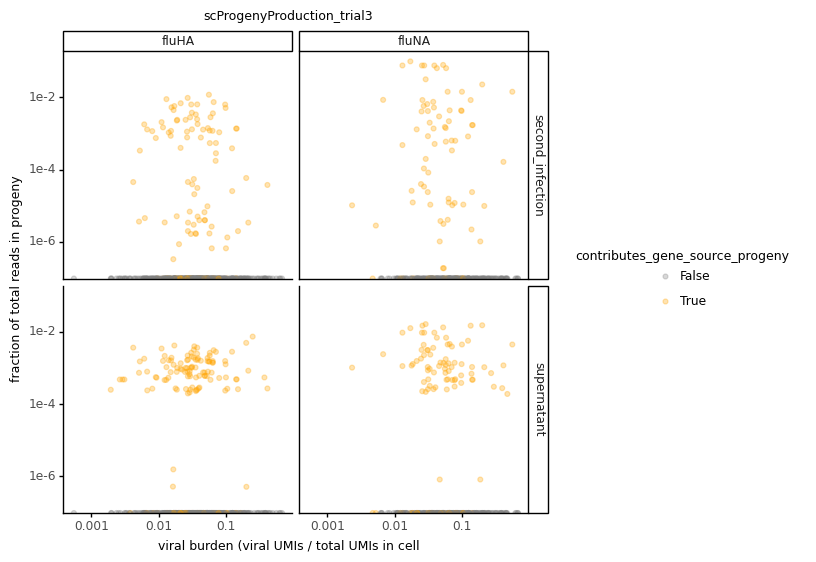

<ggplot: (8773332088631)>

In [94]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny',
                        color='contributes_gene_source_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))

display(fig)

Plot density plots and histogram of cells that contribute progeny vs don't contribute progeny

*NB I think this counts each viral bc as its own entity. Therefore, counts are not unique cell barcodes, but rather skewed by cells with high numbers of viral bc (significant or not). This plot is bad.*

In [95]:
# fig = (p9.ggplot(viral_bc_freqs
#                  .fillna(0)
#                  .query('top_viral_bc == True',
#                         engine='python'),
#                  p9.aes(x='frac_viral_UMIs',
#                         fill='contributes_gene_source_progeny')) +
#        p9.geom_density(alpha=0.2) +
#        p9.facet_grid('source~gene') +
#        p9.ggtitle(f'{expt}') +
#        p9.scale_x_log10() +
#        p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
#                y='frac cells') +
#        p9.theme(figure_size=(6, 6),
#                 plot_title=p9.element_text(size=9),
#                 axis_title=p9.element_text(size=9),
#                 legend_title=p9.element_text(size=9),
#                 legend_title_align='center') +
#        p9.scale_fill_manual(values=['grey','orange']))

# display(fig)

In [96]:
# fig = (p9.ggplot(viral_bc_freqs
#                  .query('top_viral_bc == True',
#                         engine='python'),
#                  p9.aes(x='frac_viral_UMIs',
#                         fill='contributes_gene_source_progeny')) +
#        p9.geom_histogram() +
#        p9.facet_grid('source~gene') +
#        p9.ggtitle(f'{expt}') +
#        p9.scale_x_log10() +
#        p9.scale_y_log10() +
#        p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
#                y='n cells') +
#        p9.theme(figure_size=(6, 6),
#                 plot_title=p9.element_text(size=9),
#                 axis_title=p9.element_text(size=9),
#                 legend_title=p9.element_text(size=9),
#                 legend_title_align='center') +
#        p9.scale_fill_manual(values=['grey','orange']))

# display(fig)

Look at the proportion of infected cells that contribute progeny vs those that don't and how that relates to having all viral genes. A priori, I would expect many more cells that contribute progeny to have all 8 genes than cells that don't.

In [97]:
progeny_full_genome = pd.DataFrame(
    viral_bc_freqs
    .query('infected == True and '
           'infecting_viral_tag != "both"')
    .groupby(['source', 'contributes_source_progeny', 'all_genes'])
    ['cell_barcode']
    .nunique()
    .reset_index(name='n_cells'))

progeny_full_genome = (progeny_full_genome.pivot(
    index=['source','all_genes'],
    columns='contributes_source_progeny',
    values='n_cells'))

progeny_full_genome

contributes_source_progeny  False  True 
source           all_genes              
second_infection False        239     85
                 True          76    100
supernatant      False        209    115
                 True          58    118

Run a chi-square test to see if the ratio of cells with a full genome differs in cells that contribute progeny vs cells that do not.

In [98]:
for source in ['supernatant', 'second_infection']:
    chi_data = (progeny_full_genome
                .query(f'source == "{source}"'))
    chi_result = (scipy
                  .stats
                  .chi2_contingency(observed=chi_data))
                
    print(f'Progeny source: {source}')
    print('Is the probability of contributing progeny different '
          'for cells with all 8 genes vs cells missing some genes?')

    print(f'The p-value of observing these values by chance is {chi_result[1]:.10f}.\n')

Progeny source: supernatant
Is the probability of contributing progeny different for cells with all 8 genes vs cells missing some genes?
The p-value of observing these values by chance is 0.0000000000.

Progeny source: second_infection
Is the probability of contributing progeny different for cells with all 8 genes vs cells missing some genes?
The p-value of observing these values by chance is 0.0000000000.



Visualize this data as a fraction of cells with or without all genes:

In [99]:
## Need help figuring out how to summarize this data for plotting.

# progeny_full_genome_normalized = pd.DataFrame(
#     viral_bc_freqs
#     .query('infected == True and '
#            'infecting_viral_tag != "both"')
#     .groupby(['source', 'contribute_progeny'])
#     ['all_genes']
#     .value_counts(normalize=True)
#     .reset_index(name='prop_cells'))
# progeny_full_genome_normalized

# fig = (p9.ggplot((progeny_full_genome_normalized),
#                   p9.aes(x='contribute_progeny',
#                          y='prop_cells',
#                          fill='all_genes')) +
#               p9.geom_bar(stat='identity') +
#               p9.facet_grid('source~') +
#               p9.ggtitle('infected cells\n'
#                          f'{expt}') +
#               p9.labs(x='cell contributes progeny', y='prop cells') + 
#               p9.theme(figure_size=(3, 4),
#                        plot_title=p9.element_text(size=10),
#                        axis_title=p9.element_text(size=10),
#                        legend_title=p9.element_text(size=9),
#                        legend_title_align='center') +
#               p9.scale_fill_manual(CBPALETTE[0:]))
# display(fig)

Plot the distribution of viral genes present in each cell, colored by whether they contribute progeny or not.

In [100]:
n_genes_summarized = (
    viral_bc_freqs
    .query('infected == True and '
           'infecting_viral_tag != "both"')
    .groupby(['source', 'contributes_source_progeny', 'n_viral_genes_present'])
    ['cell_barcode']
    .nunique()
    .reset_index(name='n_cells')
)

n_genes_normalized = pd.merge(
    left=n_genes_summarized,
    right=(n_genes_summarized
           .groupby(['source','contributes_source_progeny'])
           ['n_cells']
           .sum()
           .reset_index()
           .rename(columns={'n_cells':'total'})),
    on=['source', 'contributes_source_progeny'],
    how='left',
    validate='many_to_one'
)

n_genes_normalized['frac_cells'] = (n_genes_normalized['n_cells'] /
                                    n_genes_normalized['total'])

n_genes_normalized

,source,contributes_source_progeny,n_viral_genes_present,n_cells,total,frac_cells
0,second_infection,False,1.0,2,315,0.006349
1,second_infection,False,2.0,11,315,0.034921
2,second_infection,False,3.0,14,315,0.044444
3,second_infection,False,4.0,15,315,0.047619
4,second_infection,False,5.0,40,315,0.126984
5,second_infection,False,6.0,41,315,0.130159
6,second_infection,False,7.0,116,315,0.368254
7,second_infection,False,8.0,76,315,0.241270
8,second_infection,True,2.0,1,185,0.005405
9,second_infection,True,3.0,3,185,0.016216


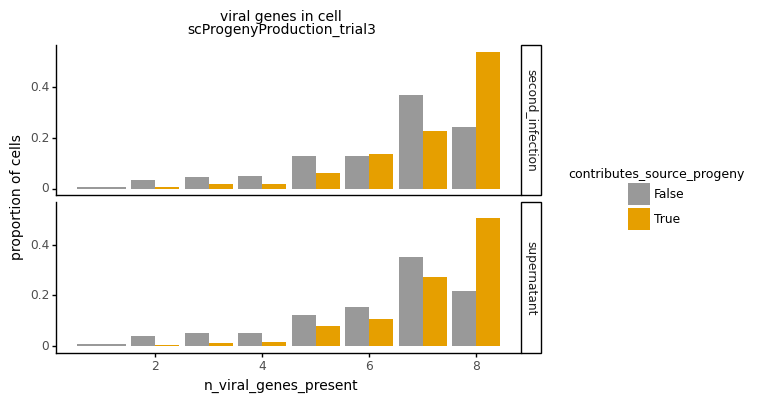

<ggplot: (8772655452685)>

In [101]:
fig = (p9.ggplot(n_genes_normalized,
                 p9.aes(x='n_viral_genes_present',
                        y='frac_cells',
                        fill='contributes_source_progeny')) +
              p9.geom_bar(stat='identity', position='dodge') +
              p9.facet_grid('source~') +
              p9.ggtitle('viral genes in cell\n'
                         f'{expt}') +
              p9.ylab('proportion of cells') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

## What is the effect of each gene on viral outcomes

Relationship between each gene's expression adn viral burden

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


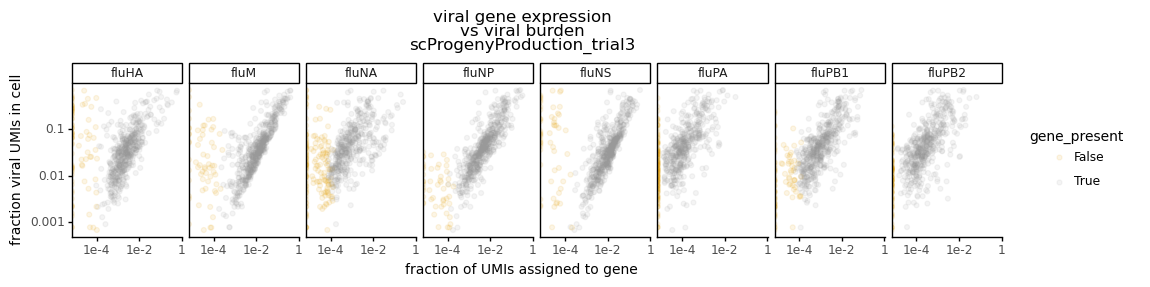

<ggplot: (8772646510186)>

In [102]:
fig = (p9.ggplot((viral_gene_expression_long
                  .query('infected == True')),
                 p9.aes(x='frac_gene_UMIs',
                        y='frac_viral_UMIs',
                        color='gene_present')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'vs viral burden\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs assigned to gene',
               y='fraction viral UMIs in cell') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(12, 2),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

Bring in progeny production information:

In [103]:
(viral_bc_freqs[['cell_barcode',
                           'source',
                           'contributes_source_progeny']]
           .drop_duplicates())

,cell_barcode,source,contributes_source_progeny
0,AAACCCAGTAACAAGT,supernatant,False
2,AAACCCAGTAACAAGT,second_infection,False
4,AAACCCATCATTGCTT,supernatant,False
6,AAACCCATCATTGCTT,second_infection,False
8,AAACGAAAGATGTTGA,supernatant,False
...,...,...,...
18372,TTTGATCTCGCATTGA,second_infection,False
18374,TTTGGAGGTATCGTTG,supernatant,True
18377,TTTGGAGGTATCGTTG,second_infection,True
18380,NaN,second_infection,False


In [104]:
viral_gene_expression_long = pd.merge(
    left=viral_gene_expression_long,
    right=(viral_bc_freqs[['cell_barcode',
                           'source',
                           'contributes_source_progeny']]
           .drop_duplicates()),
    on=['cell_barcode'],
    how='left'
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs,limit_frac,limit_UMIs,null_P,gene_present,source,contributes_source_progeny
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.000000,0.000000,0.000000,1.000000,False,supernatant,False
1,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.000000,0.000000,0.000000,1.000000,False,second_infection,False
2,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025,0.500000,0.000000,0.000000,0.000000,True,supernatant,False
3,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025,0.500000,0.000000,0.000000,0.000000,True,second_infection,False
4,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000,0.000000,0.000000,0.000000,1.000000,False,supernatant,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53883,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000,0.000000,0.000063,1.795923,1.000000,False,second_infection,False
53884,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720,0.355444,0.000063,4.116977,0.000000,True,supernatant,True
53885,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720,0.355444,0.000063,4.116977,0.000000,True,second_infection,True
53886,TTTGTTGAGTGCAGCA,False,none,58559,4,fluNS,2,0.000068,0.000034,0.500000,0.000063,3.701385,0.883926,False,supernatant,False


In [105]:
each_gene = (viral_gene_expression_long
             .query('infected == True and '
                    'infecting_viral_tag != "both"')
             .groupby(['source', 'gene','gene_present'])
             ['contributes_source_progeny']
             .value_counts()
             .reset_index(name='n_cells'))

each_gene_normalized = pd.merge(
    left=each_gene,
    right=(each_gene
           .groupby(['source','gene','contributes_source_progeny'])
           ['n_cells']
           .sum()
           .reset_index()
           .rename(columns={'n_cells':'total'})),
    on=['source', 'gene', 'contributes_source_progeny'],
    how='left',
    validate='many_to_one'
)

each_gene_normalized['frac_cells'] = (each_gene_normalized['n_cells'] /
                                      each_gene_normalized['total'])


each_gene_normalized

,source,gene,gene_present,contributes_source_progeny,n_cells,total,frac_cells
0,second_infection,fluHA,False,False,68,315,0.215873
1,second_infection,fluHA,False,True,5,185,0.027027
2,second_infection,fluHA,True,False,247,315,0.784127
3,second_infection,fluHA,True,True,180,185,0.972973
4,second_infection,fluM,False,False,51,315,0.161905
...,...,...,...,...,...,...,...
59,supernatant,fluPB1,True,True,201,233,0.862661
60,supernatant,fluPB2,False,False,57,267,0.213483
61,supernatant,fluPB2,False,True,32,233,0.137339
62,supernatant,fluPB2,True,False,210,267,0.786517


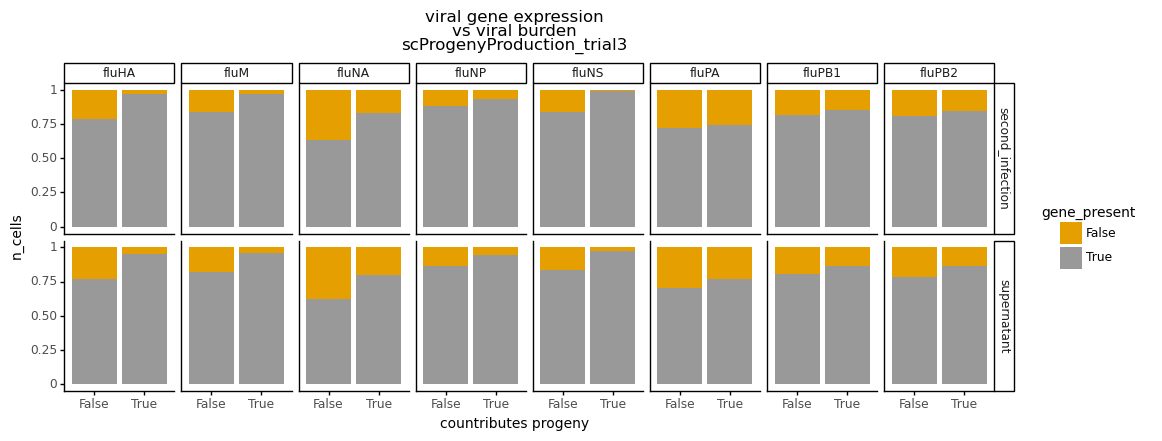

<ggplot: (8772655871684)>

In [106]:
fig = (p9.ggplot(each_gene_normalized,
                 p9.aes(x='factor(contributes_source_progeny)',
                        y='frac_cells',
                        fill='gene_present')) +
       p9.geom_bar(stat='identity') +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'vs viral burden\n'
                  f'{expt}') +
       p9.labs(x='countributes progeny',
               y='n_cells') +
       p9.theme(figure_size=(12, 4),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)